## Import modules
If you don't have these, they can all be installed via pip install on the command line

In [1]:
import bezier
from tkinter import *
import numpy as np
from PIL import ImageGrab

## Drawing and click functions
Have a list of strokes, left click adds a control point to the current stroke, right click moves on to the next stroke, middle click clears the canvas.

In [4]:
currChar = [] #list of strokes
currStroke = [] #list of control points

def clickEventPoint(event): #click event
    global currChar #force function to use global vars
    global currStroke
    
    #print("clicked at", event.x, event.y)
    tempChar = currChar.copy()
    currStroke.append([event.x, event.y])
    tempChar.append(currStroke)
    graphChar(tempChar)
    #print(tempChar)
    
def clickEventStroke(event): #click event
    global currChar #force function to use global vars
    global currStroke
    
    currChar.append(currStroke)
    currStroke = [] #new stroke
    graphChar(currChar)

def clickEventClear(event): #click event
    global currChar #force function to use global vars
    global currStroke
    global drawChar
    
    currChar = [] #reset lists
    currStroke = []
    graphChar(currChar) #just redraw with the now empty currChar data
    
def graphChar(strokeList): #draw the char
    global currChar #force function to use global vars
    global currStroke
    global drawChar
    
    pr = 3 #point radius size
    lineWidth = 35
    evalPoints = np.linspace(0.0, 1.0, 50) #start, end, resol, parametric t values
    canvas.delete("all") #clear the canvas of all objects
    canvas.create_text(400, 400, text=drawChar, font=('Microsoft YaHei','500'), fill='#555555')
    for stroke in strokeList:
        #graph control points
        for point in stroke: #control points, 
            canvas.create_oval(point[0]-pr, point[1]-pr, point[0]+pr, point[1]+pr, fill='#00AA00')
        if(len(stroke)>1):
            canvas.create_line(stroke, fill ='#00AA00', width=1)
        #graph actual curve (bezier, use package)
        nodes = np.array(stroke).transpose()
        curve = bezier.Curve(nodes, degree=len(stroke)-1)
        curvePoints = curve.evaluate_multi(evalPoints).transpose().tolist() #[x_value list, y_value list]
        canvas.create_line(curvePoints, fill='#000000', width=lineWidth)
        
def onTextChange(event): #user entered a char
    global drawChar
    drawChar = charEntry.get()
    clickEventClear(0) #default arg of 0 as the event arg isn't used
    
def onTextClear(event): #user is going to enter a char, clear the current char (1 max char in entry box)
    entryText.set('')

#from: https://www.pythonfixing.com/2022/06/fixed-how-to-save-tkinter-canvas-as.html
def saveCanvasAsImage(): #literally screen captures 
    x=root.winfo_rootx()+canvas.winfo_x()
    y=root.winfo_rooty()+canvas.winfo_y()
    x1=x+canvas.winfo_width()
    y1=y+canvas.winfo_height()
    print(x,y,x1,y1)
    ImageGrab.grab().crop((x,y,x1,y1)).save("tempChar.png")

## Basic tkinter app to run our canvas
Setup the basic app, and connect the event functions on mouse clicks

In [ ]:
drawChar = '㇀'
canvasSize = 800

# Create object and size
root = Tk()
root.geometry( "800x850" )

#add label for draw char, label, text
charLabel = Label(root, text = "Char: ")
charLabel.pack()

#handle user typing in a char
entryText = StringVar()
charEntry = Entry(root, width = 10, justify="center", textvariable=entryText)
entryText.set(drawChar) #default char
charEntry.bind("<KeyPress>", onTextClear) #user is about to finish typing a char
charEntry.bind("<KeyRelease>", onTextChange) #user entered a char
charEntry.pack()

#button for processing the button
processBtn = Button(root, text ="Gen. Strokes", command = saveCanvasAsImage)
processBtn.pack()

#canvas for drawing characters and strokes
canvas = Canvas(root, bg="white", height=canvasSize, width=canvasSize) #our drawing board
canvas.create_text(400, 400, text=drawChar, font=('Microsoft YaHei','500'), fill='#555555')
clickEventClear(0) #default arg of 0 as the event arg isn't used
canvas.pack()

#reset the lists before we re-run the tkinter app
currChar = []
currStroke = []

canvas.bind("<Button-1>", clickEventPoint) #setup the left click event, add a control point
canvas.bind("<Button-2>", clickEventClear) #setup the left click event, clear the canvas
canvas.bind("<Button-3>", clickEventStroke) #setup the right click event, finalize stroke

root.mainloop() #run the app

In [19]:
print(currChar)

[[[166, 542], [455, 462], [636, 181]]]


## Processing in Image down to "vertices"
Decay an image continually by the following rule

Run the following algorithm:

    for every pixel:
        if it is black remove on the following condition:
            if there exists a white neighbor (4 nearest)
            if there exists a black neighbor (4 nearest)
        do a pass one pixel at a time (don't update the image all at once
        
How fun doesn't work,
Different algorithm:
    
    for every pixel:
        mark a pixel if it borders a white pixel (8 neigh)
        delete a marked pixel if it borders a black pixel which isn't marked
    do whole image passes at a time
    continue this until there is no change after an iteration

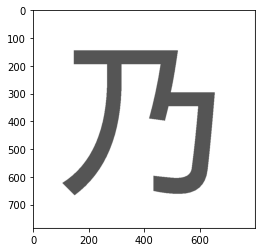

In [13]:
from matplotlib import image
from matplotlib import pyplot as plt

rawImage = image.imread('tempChar.png')
plt.imshow(rawImage)

800


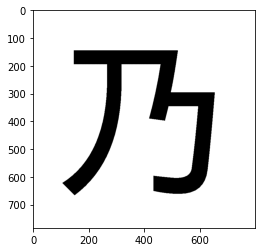

In [14]:
origShape = np.shape(rawImage)
print(origShape[1])
simpleImage = np.ones((origShape[0], origShape[1])) #grayscale, each pixel should be black or white
#already all white, fill in black pixels
blackMask = np.logical_or(rawImage[:,:,0]<.8, rawImage[:,:,1]<.8, rawImage[:,:,2]<.8) #white enough
simpleImage[blackMask] = 0 #black pixels

plt.imshow(simpleImage, cmap='gray', vmin=0, vmax=1)

In [15]:
def simplifyImage(orig): #return next iteration and bool isChanged flag
    newImage = orig.copy()
    imgSum = getNeighSum2(orig) #if val >= 1, it has a white neighbor and is marked

    invertedImgSum = np.zeros(np.shape(imgSum)) #make 1 if unmarked, 0 if white/marked
    invertedImgSum[imgSum == 0] = 1 #1 for unmarked, all other pixels are already 0
    unmarkedSum = getNeighSum2(invertedImgSum) #if cell has val >= 1, there exists an unmarked neighbor

    #make a cell white if it is marked and exists an unmarked black neighbor
    deleteMask = np.logical_and(imgSum >= 1, unmarkedSum >= 1)
    newImage[deleteMask] = 1 #make white
    return newImage, not np.array_equiv(newImage, orig)

def getNeighSum(orig): #9 sum neighbor (including itself)
    imShape = np.shape(orig)
    neighSums = np.zeros(np.shape(orig))
    #take the 9 neigh offset frames and add to the corresponding pixel (note we ignore edges)
    for offY in range(0,3): #-1 to 1
        for offX in range(0,3): #-1 to 1
            neighSums[1:-1, 1:-1] += orig[ offY: imShape[0] + (-2+offY) , offX: imShape[1] + (-2+offX)]
    #now any cell with a white neigh (including itself) has a val >= 1
    return neighSums

def getNeighSum2(orig): #5 sum neighbor (including itself)
    imShape = np.shape(orig)
    neighSums = np.zeros(np.shape(orig))
    #take the 9 neigh offset frames and add to the corresponding pixel (note we ignore edges)
    for offY in range(0,3,2): #-1, 1
        neighSums[1:-1, 1:-1] += orig[ offY: imShape[0] + (-2+offY) , 1:-1 ]
    for offX in range(0,3,2): #-1, 1
        neighSums[1:-1, 1:-1] += orig[ 1:-1 , offX: imShape[1] + (-2+offX) ]
    neighSums[1:-1, 1:-1] += orig[ 1:-1, 1:-1 ] #count the center pixel itself
    #now any cell with a white neigh (including itself) has a val >= 1
    return neighSums

def removeLonely(orig): #remove a black pixel if it has no black neighbors
    newImage = orig.copy()
    neighSums = getNeighSum2(orig) #5 neighbor sum, surrounded if val == 4
    blackMask = np.logical_and(neighSums == 4, orig == 0) #black and surrounded by white
    newImage[blackMask] = 1 #make white
    return newImage

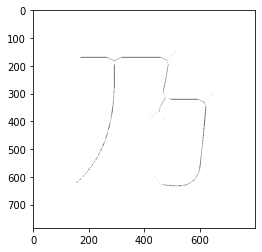

In [16]:
vImg = simpleImage.copy()
changed = True
i=0
while(changed): #keep refining until image is as simplified as possible.
    vImg, changed = simplifyImage(vImg)
vImg = removeLonely(vImg)
plt.imshow(vImg, cmap='gray', vmin=0, vmax=1)
#plt.imsave("testRefine.png", vImg, cmap='gray', vmin=0, vmax=1)

In [17]:
plt.imsave("testRefined4.png", vImg, cmap='gray', vmin=0, vmax=1)

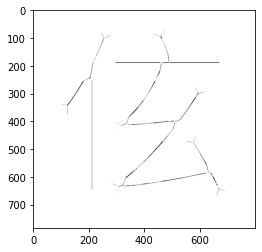

In [204]:
#vImg = simpleImage.copy()
vImg, changed = simplifyImage(vImg)
plt.imshow(vImg, cmap='gray', vmin=0, vmax=1)

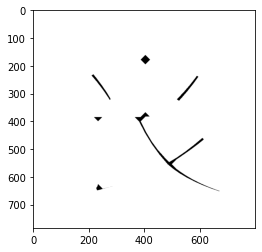

In [118]:
#apply algorithm
vImg2 = vImg.copy()
smallMask = np.ones((5,5))
for i in range(1, origShape[0] - 2): #range to avoid out of bounds error
    for j in range(1, origShape[1] - 2):
        if(vImg[i,j] == 1): #skip if white pixel
            continue
        whiteNeighs = vImg[i-2:i+3, j-2:j+3] == smallMask
        hasWhiteNeigh = vImg[i-1,j]==1 or vImg[i+1,j]==1 or vImg[i,j-1]==1 or vImg[i,j+1]==1
        hasBlackNeigh = vImg[i-1,j]==0 or vImg[i+1,j]==0 or vImg[i,j-1]==0 or vImg[i,j+1]==0
        if(hasWhiteNeigh and hasBlackNeigh): #has white and black neighbor not a vertice, delete
            vImg2[i,j] = 1
vImg = vImg2.copy()
        
plt.imshow(vImg2, cmap='gray', vmin=0, vmax=1)

In [114]:
plt.imsave('tempCharVertices.png', vImg2, cmap='gray', vmin=0, vmax=1)

In [120]:
smallMask = np.ones((5,5))
np.count(vImg[8-2:8+3, 723-2:723+3] == smallMask)

AttributeError: module 'numpy' has no attribute 'count'

In [ ]:
# 130.0     500.0' fractionalDistance='0.0' />
# 420.0     500.0' fractionalDistance='0.60245219862639732' />
# 405.34375 483.53125' fractionalDistance='0.64825099607375425' />
# 389.875   467.125' fractionalDistance='0.69509430376468673' />
# 373.59375 450.78125' fractionalDistance='0.74301917064145917' />
# 356.5     434.5' fractionalDistance='0.79206019445633258' />
# 338.59375 418.28125' fractionalDistance='0.84224966477024621' />
# 319.875   402.125' fractionalDistance='0.89361770547550479' />
# 300.34375 386.03125' fractionalDistance='0.94619241463617076' />
# 280.0     370.0' fractionalDistance='1.0' />